# 1. Pasos previos

## 1.1. Instalación e importación de paquetes

In [ ]:
%pip install torch torchvision fastai segmentation-models-pytorch opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 797.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=623edd689c0583ab8234ee2abbe8cf0a5caa5f99bea732c923297fc6668eb9fc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=99cef09c46130446c2c5ffc310decfc61e48bd66eb8fe04a5717cca546d88720
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import csv

## 1.2. Comprobación de disponibilidad de gráficas

In [ ]:
!nvidia-smi

Sun Jan 14 02:16:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

Tesla T4
True


## 1.3. Carga de Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 2. Carga de datos

## 2.1 Declaración de funciones auxiliares para la carga de datos

In [ ]:
def get_y_fn(x):
    """
    Dada la ruta de una imagen, devuelve la ruta de su máscara correspondiente.
    """
    return Path(str(x).replace('src', 'gt').replace('.jpg', '.png'))


def get_items(path):
    """
    Obtiene una lista de todas las imágenes en el directorio 'src'.
    """
    return get_image_files(path/'src')

In [ ]:
# Definición de la función para normalizar la máscara
def normalize_mask(mask, mapping):
    if mask.ndim != 3 or mask.shape[-1] != 3:
        raise ValueError(
            "La máscara debe ser una imagen RGB con 3 canales de color.")
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, c in mapping.items():
        mask_class[(mask == color).all(axis=-1)] = c
    return mask_class

# Definición de la función para denormalizar la máscara
def denormalize_mask(mask_class, mapeo):
    inverse_map = {v: k for k, v in mapeo.items()}
    h, w = mask_class.shape
    mask_color = np.zeros((h, w, 3), dtype=np.uint8)
    for c in np.unique(mask_class):
        color = inverse_map[c]
        mask_color[mask_class == c] = color
    return mask_color


# Mapeo de color a clase para la normalización de máscaras
mapping_class_color = {
    (0, 0, 0): 0,     # Clase 0
    (128, 64, 128): 1,  # Clase 1 - Road
    (0, 0, 142): 2,  # Clase 2 - Car en carretera
    (255, 255, 0): 3
}

# Función para obtener la máscara normalizada como floats
def get_mask(item):
    msk_path = get_y_fn(item)
    msk = np.array(PILImage.create(msk_path))

    # Normalizar la máscara y dejarla como floats
    normalized_mask = normalize_mask(msk, mapping_class_color)

    return PILMask.create(normalized_mask.astype(np.int32))


In [ ]:
# Función para el splitter
def splitter_func(items):
    # Lista de nombres de imágenes para validación
    nombres_validacion = ['granada9.jpg', 'granada13.jpg', 'granada34.jpg', 'granada42.jpg', 'granada45.jpg', 'granada56.jpg', 'granada69.jpg', 'granada76.jpg', 'granada78.jpg', 'granada89.jpg']

    valid_idx = [i for i, item in enumerate(items) if Path(item).name in nombres_validacion]
    train_idx = [i for i, item in enumerate(items) if Path(item).name not in nombres_validacion]
    return train_idx, valid_idx

In [ ]:
def add_shadow(image, num_shadows, min_opacity, max_opacity):
    height, width = image.shape[:2]
    shadow_image = image.copy()

    for _ in range(num_shadows):
        # Randomly generate the shadow polygon
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        x3, y3 = random.randint(0, width), random.randint(0, height)
        x4, y4 = random.randint(0, width), random.randint(0, height)

        # Create a black polygon to simulate the shadow
        poly = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        cv2.fillPoly(shadow_image, [poly], (0, 0, 0))

        # Blending the shadow with the image
        alpha = random.uniform(min_opacity, max_opacity)
        mask = shadow_image.astype(bool)
        shadow_image = cv2.addWeighted(shadow_image, alpha, image, 1 - alpha, 0, image)
        image[mask] = shadow_image[mask]

    return image

class ShadowTransform(Transform):
    """
    Custom Transform for adding shadows.
    """
    def __init__(self, num_shadows=3, min_opacity=0.5, max_opacity=0.75):
        self.num_shadows = num_shadows
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity

    def encodes(self, x: PILImage):
        return add_shadow(x, self.num_shadows, self.min_opacity, self.max_opacity)

In [ ]:
# Transformaciones por defecto
aug_transforms = aug_transforms(mult=2, do_flip=True, flip_vert=True,
                                max_rotate=90., min_zoom=0.8, max_zoom=3.0,
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75,
                                p_lighting=0.75, xtra_tfms=None, size=None,
                                mode='bilinear', pad_mode='reflection',
                                align_corners=True, batch=False, min_scale=1)

## 2.2 Creación del DataLoader

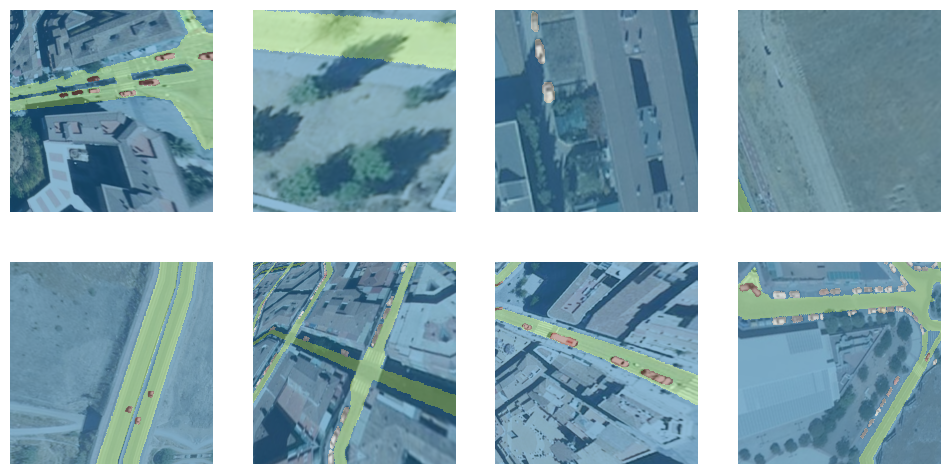

In [ ]:
# Definir el número de clases en tu conjunto de datos
num_classes = 4

path_to_dataset = Path('/content/drive/My Drive/FotosGranada2/train')

# Definir el formato de los bloques de datos
data = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=splitter_func,
    item_tfms=RandomResizedCrop(400, min_scale=0.8),
    batch_tfms=[*aug_transforms,Normalize.from_stats(*imagenet_stats)]
)

# Crea DataLoaders y muestra un lote de entrenamiento
dls = data.dataloaders(path_to_dataset, bs=16)
dls.train.show_batch(max_n=8)

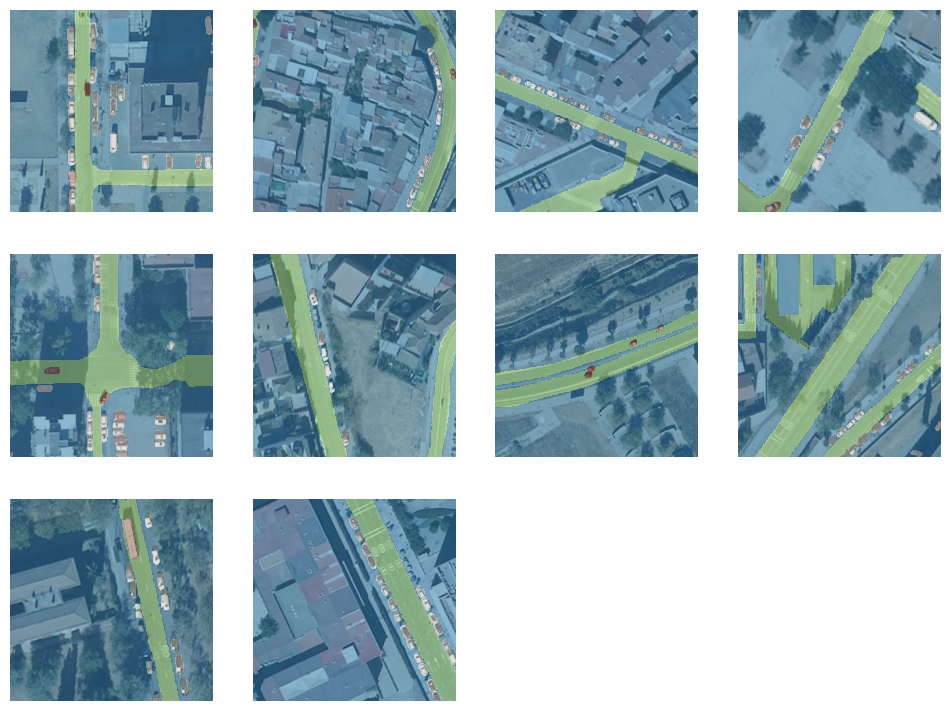

In [ ]:
dls.valid.show_batch(max_n=10)

In [ ]:
print("Tamaño del conjunto de entrenamiento: ",len(dls.train.items))
print("Tamaño del conjunto de validación: ",len(dls.valid.items))

Tamaño del conjunto de entrenamiento:  70
Tamaño del conjunto de validación:  10


# 3. Carga de la arquitectura con sus pesos

In [ ]:
learner = load_learner('/content/drive/My Drive/deeplab.pkl', cpu=True)
model = learner.model

In [ ]:
# Obtener el número de canales de entrada de la capa Conv2d en segmentation_head
in_channels = model.segmentation_head[0].in_channels

# Reemplazar la capa Conv2d por una nueva con 4 canales de salida
model.segmentation_head[0] = nn.Conv2d(in_channels, 4, kernel_size=(1, 1))

# Actualizar el Learner con el modelo modificado
learner.model = model


In [ ]:
learner = Learner(dls, model, loss_func=FocalLoss(), metrics=[foreground_acc, DiceMulti(), JaccardCoeffMulti()])

In [ ]:
learner.summary()

/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:390: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


DeepLabV3Plus (Input shape: 16 x 3 x 400 x 400)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 200 x 200 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 100 x 100 
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     16 x 256 x 100 x 10 
Conv2d                                    16384      True      
BatchNorm2d                     

# 4. Entrenamiento del modelo

## 4.1. Declaración de funciones auxiliares

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off()
           for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i ==
                0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
# Function to save the metrics to a csv file
def save_metrics_to_csv(learner, file_path='deeplab_metrics.csv', **kwargs):
    recorder = learner.recorder
    metrics = np.stack(recorder.values)
    names = recorder.metric_names[1:-1]

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Escribir las cabeceras (nombres de las métricas)
        writer.writerow(['epoch'] + names)

        # Escribir las métricas por época
        for epoch, metric_values in enumerate(metrics):
            writer.writerow([epoch + 1] + list(metric_values))

    print(f"Metrics saved to {file_path}")

## 4.2 Actualización de pesos

In [ ]:
learner.fine_tune(epochs=10,freeze_epochs=5)
# learner.fit_one_cycle(10)

In [ ]:
save_metrics_to_csv(learner, file_path='deeplab_granada_metrics2.csv')

Metrics saved to deeplab_granada_metrics2.csv


# 5. Evaluación de resultados

## 5.1. Adaptación de las métricas para la evaluación

In [ ]:
def foreground_acc_simple(inp, targ, bkg_idx=0):
    """
    Calcula la precisión para segmentación multiclase ignorando el fondo.

    Parámetros:
    inp (numpy.ndarray): Imagen de predicciones con valores de clase, forma [H, W].
    targ (numpy.ndarray): Imagen de etiquetas verdaderas con valores de clase, forma [H, W].
    bkg_idx (int): Índice que representa el fondo.

    Retorna:
    float: Precisión para las clases que no son de fondo. Devuelve 1 si todo es fondo.
    """

    # Crear una máscara para ignorar los píxeles de fondo
    mask = targ != bkg_idx

    # Verificar si todos los píxeles son de fondo (mask está vacía)
    if not mask.any():
        return 1.0  # Devolver 1 si todo es fondo

    # Calcular y devolver la precisión
    return np.mean((inp[mask] == targ[mask]).astype(np.int64))


In [ ]:
def dice_multi(inp, targ):
    """
    Calcula la métrica DiceMulti para dos matrices numpy inp y targ.

    Parámetros:
    inp (numpy.ndarray): Matriz de predicciones con valores de clase, forma [H, W].
    targ (numpy.ndarray): Matriz de etiquetas verdaderas con valores de clase, forma [H, W].

    Retorna:
    float: Métrica DiceMulti para las clases en las matrices inp y targ.
    """
    num_classes = max(np.max(inp), np.max(targ)) + 1  # Número de clases en las matrices
    inter = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for c in range(num_classes):
        p = (inp == c).astype(np.float32)
        t = (targ == c).astype(np.float32)
        c_inter = np.sum(p * t)
        c_union = np.sum(p + t)
        inter[c] += c_inter
        union[c] += c_union

    binary_dice_scores = np.zeros(num_classes)
    for c in range(num_classes):
        binary_dice_scores[c] = 2. * inter[c] / (union[c] + 1e-8)  # Evitar división por cero

    return np.nanmean(binary_dice_scores)


In [ ]:
import numpy as np
from enum import Enum

class ActivationType(Enum):
    Sigmoid = 'sigmoid'
    No = None

def jaccard_multi(inp, targ, thresh=0.5, sigmoid=True, labels=None, pos_label=1, average='macro', sample_weight=None):
    """
    Calcula la métrica JaccardMulti para dos matrices numpy inp y targ.

    Parámetros:
    inp (numpy.ndarray): Matriz de predicciones con valores de clase, forma [H, W].
    targ (numpy.ndarray): Matriz de etiquetas verdaderas con valores de clase, forma [H, W].
    thresh (float): Umbral para la activación sigmoidal si se aplica.
    sigmoid (bool): Si True, aplica una activación sigmoidal a las predicciones.
    labels (list): Lista de etiquetas a considerar.
    pos_label (int): Etiqueta positiva a considerar.
    average (str): Tipo de promedio ('macro', 'micro', 'weighted' o None).
    sample_weight (numpy.ndarray): Peso para cada muestra.

    Retorna:
    float: Métrica JaccardMulti para las clases en las matrices inp y targ.
    """
    if sigmoid:
        inp = 1.0 / (1.0 + np.exp(-inp))
    inp = (inp > thresh).astype(np.int32)
    targ = (targ == pos_label).astype(np.int32)

    if labels is None:
        labels = np.unique(np.concatenate((inp, targ)))

    if sample_weight is None:
        sample_weight = np.ones_like(inp)

    jaccard_scores = []

    for label in labels:
        intersection = np.sum((inp == label) & (targ == label) & (sample_weight != 0))
        union = np.sum(((inp == label) | (targ == label)) & (sample_weight != 0))

        if union == 0:
            jaccard_scores.append(0.0)
        else:
            jaccard_scores.append(intersection / union)

    if average == 'macro':
        return np.mean(jaccard_scores)
    elif average == 'micro':
        return np.sum(jaccard_scores) / max(1, np.sum(sample_weight))
    elif average == 'weighted':
        return np.sum(np.array(jaccard_scores) * np.array(sample_weight)) / max(1, np.sum(sample_weight))
    else:
        return jaccard_scores

## 5.2. Creación del DataLoader para Test

In [ ]:
def splitter_all_train(items):
    train_idx = list(range(len(items)))
    valid_idx = []  # Lista vacía para el conjunto de validación
    return train_idx, valid_idx

path_to_test = Path('/content/drive/My Drive/FotosGranada2/val')

# Definir el formato de los bloques de datos
data_test = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(4))),
    get_items=get_items,
    get_y=get_mask,
    splitter=splitter_all_train,
    item_tfms=Resize(400),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

# Crea DataLoaders y muestra un lote de entrenamiento
dls_test = data_test.dataloaders(path_to_test, bs=16)
print("Tamaño del conjunto de evaluación: ",len(dls_test.items))

Tamaño del conjunto de evaluación:  10


## 5.3. Ejecución del test

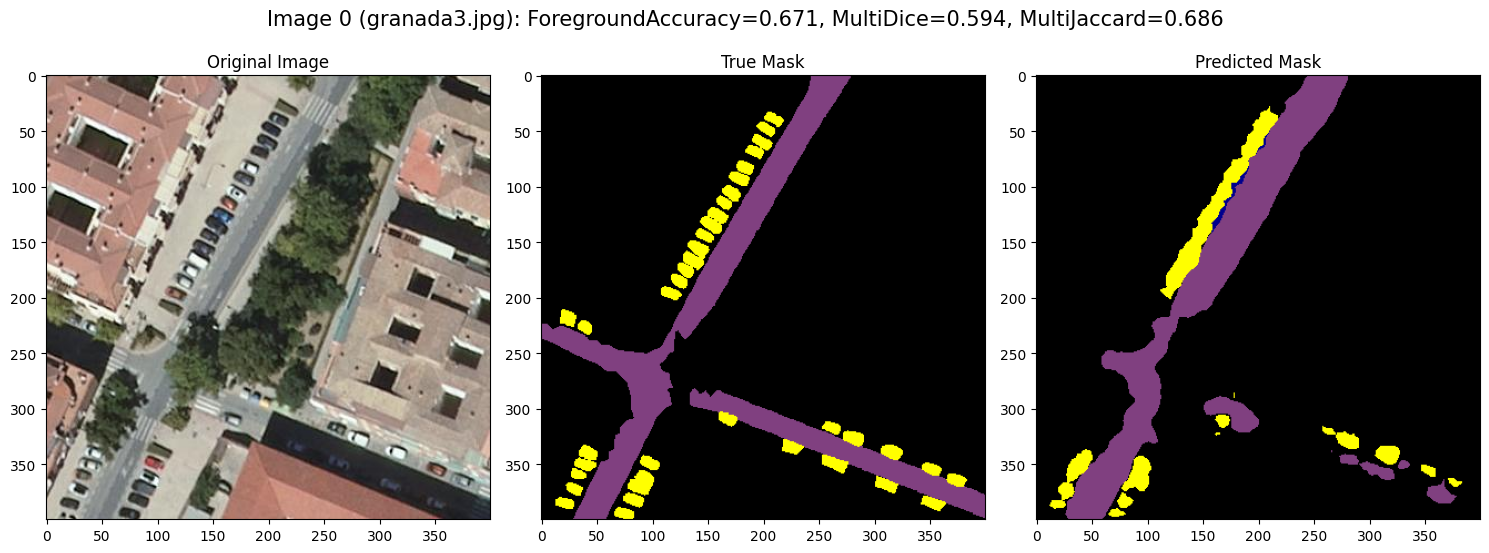

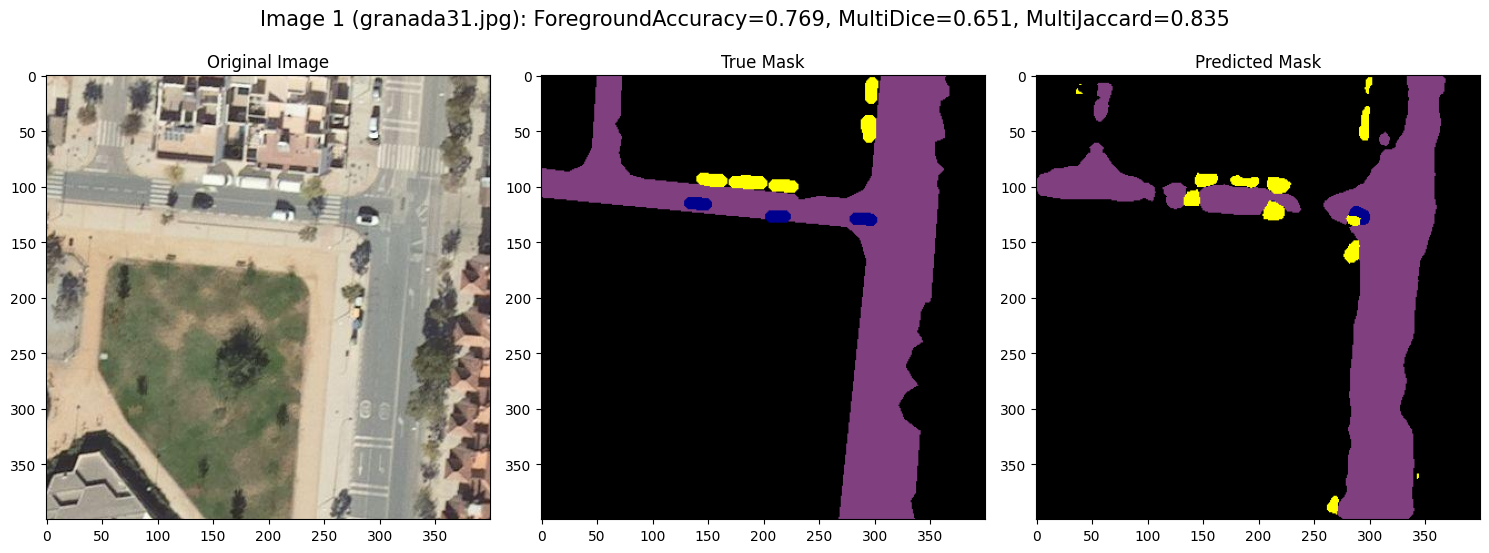

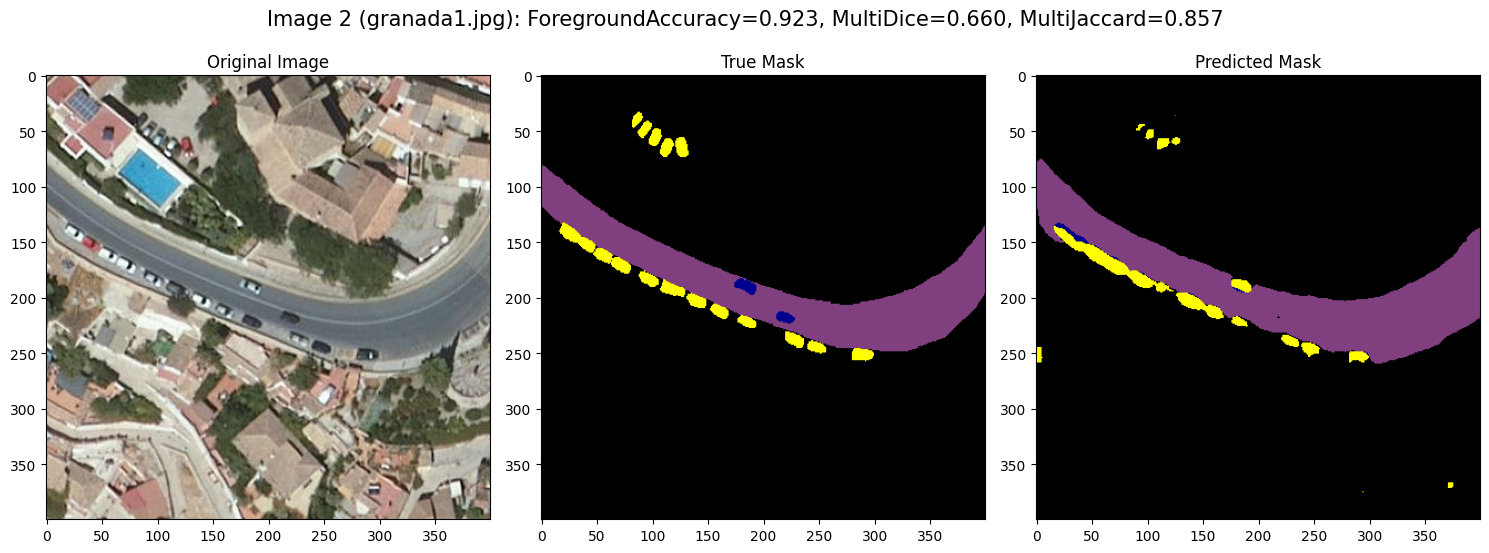

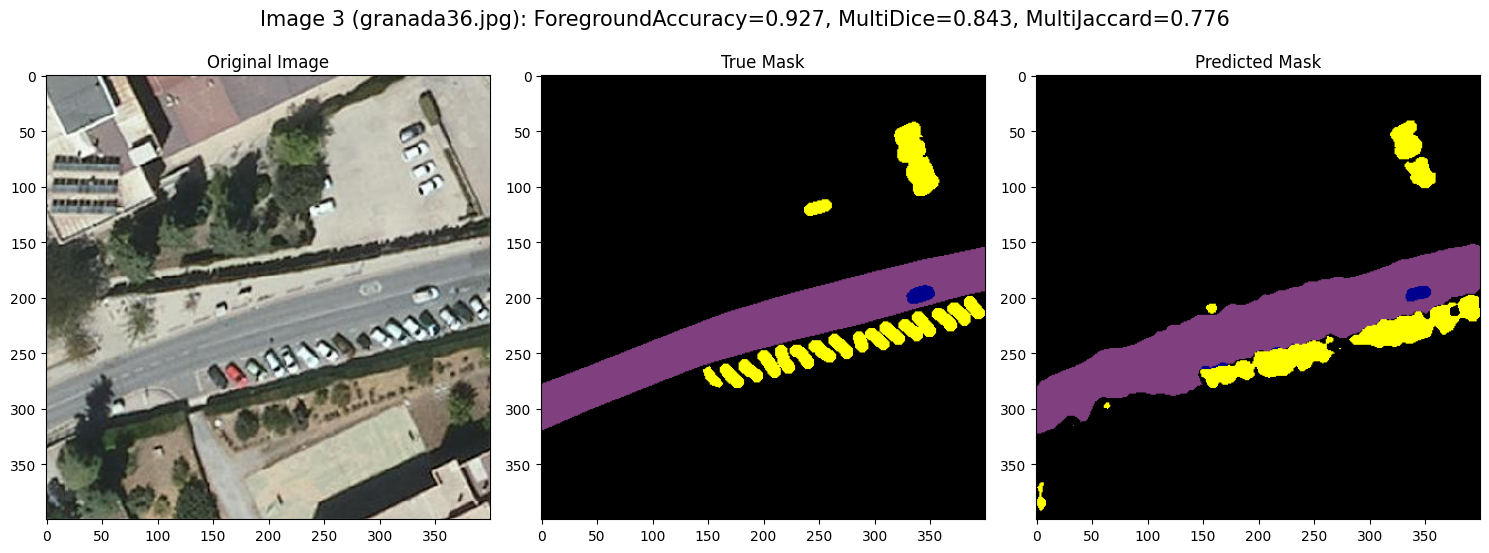

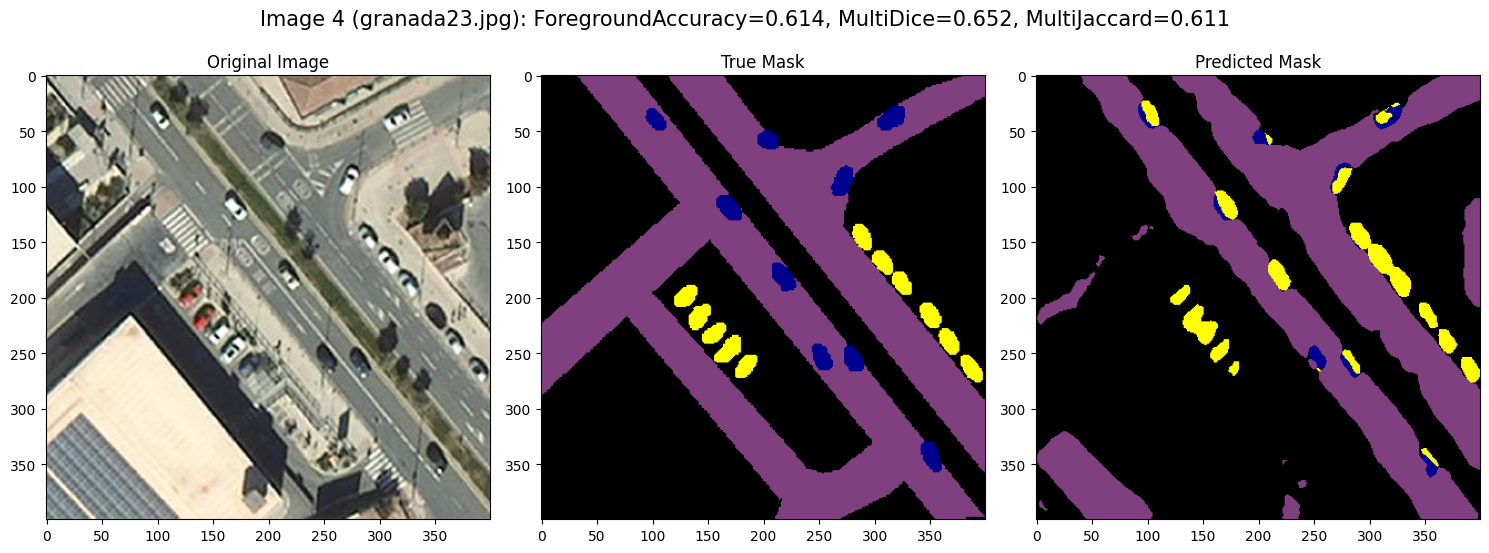

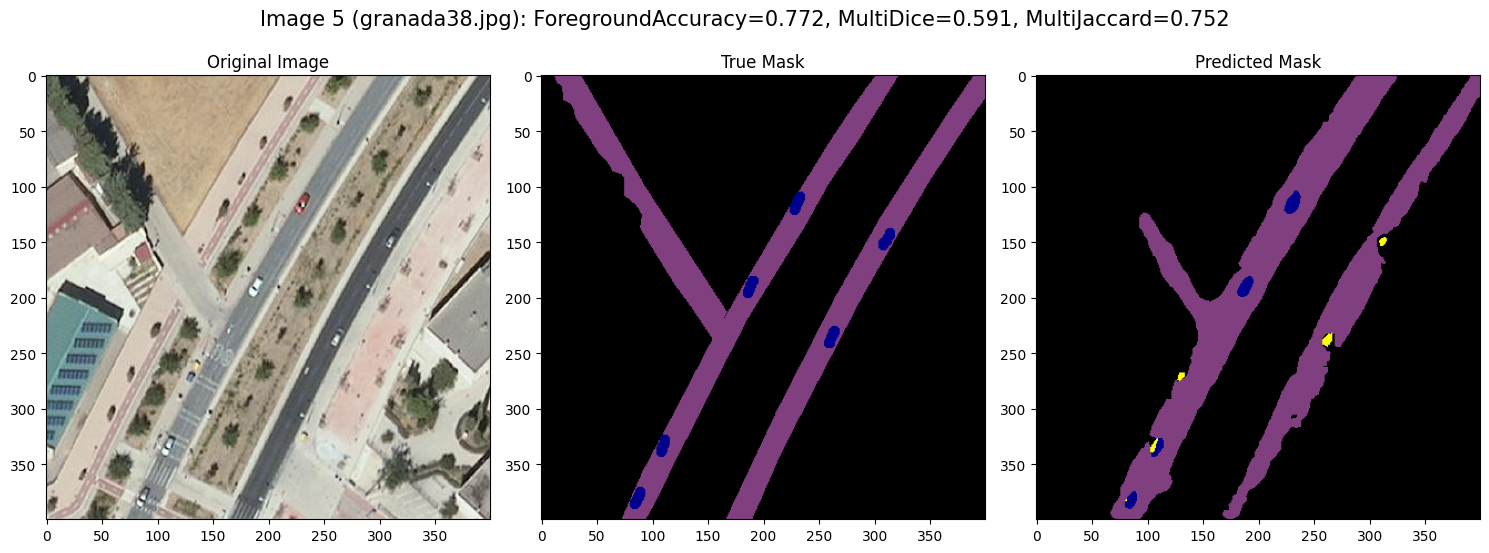

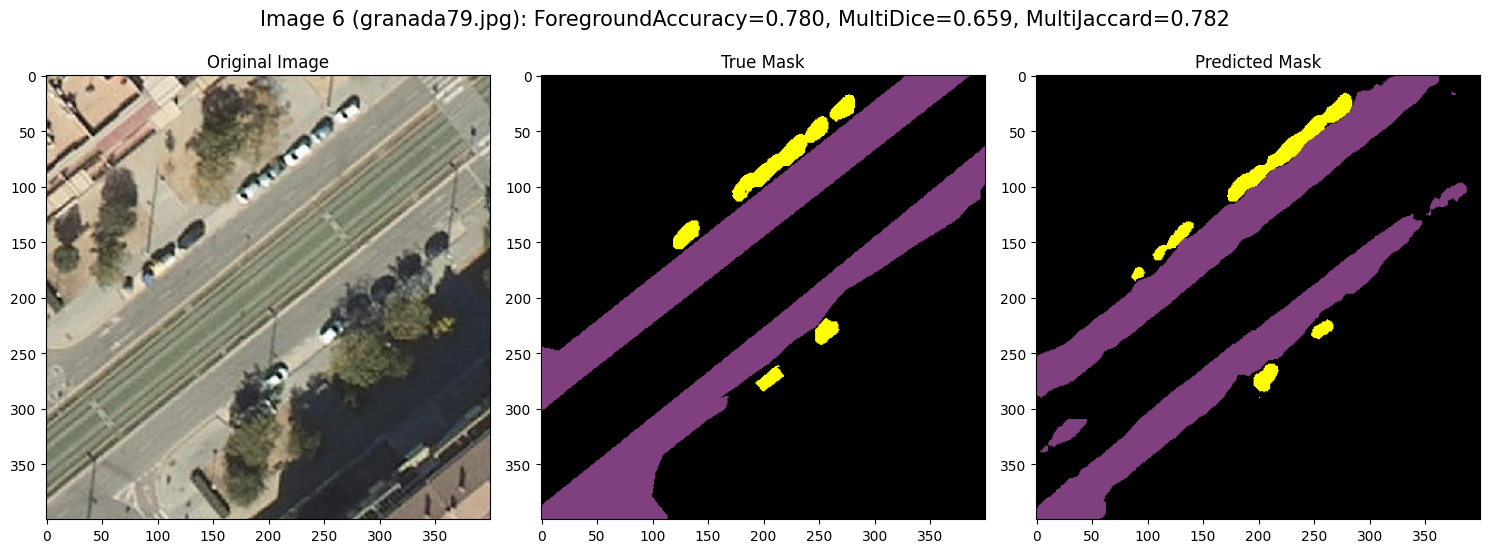

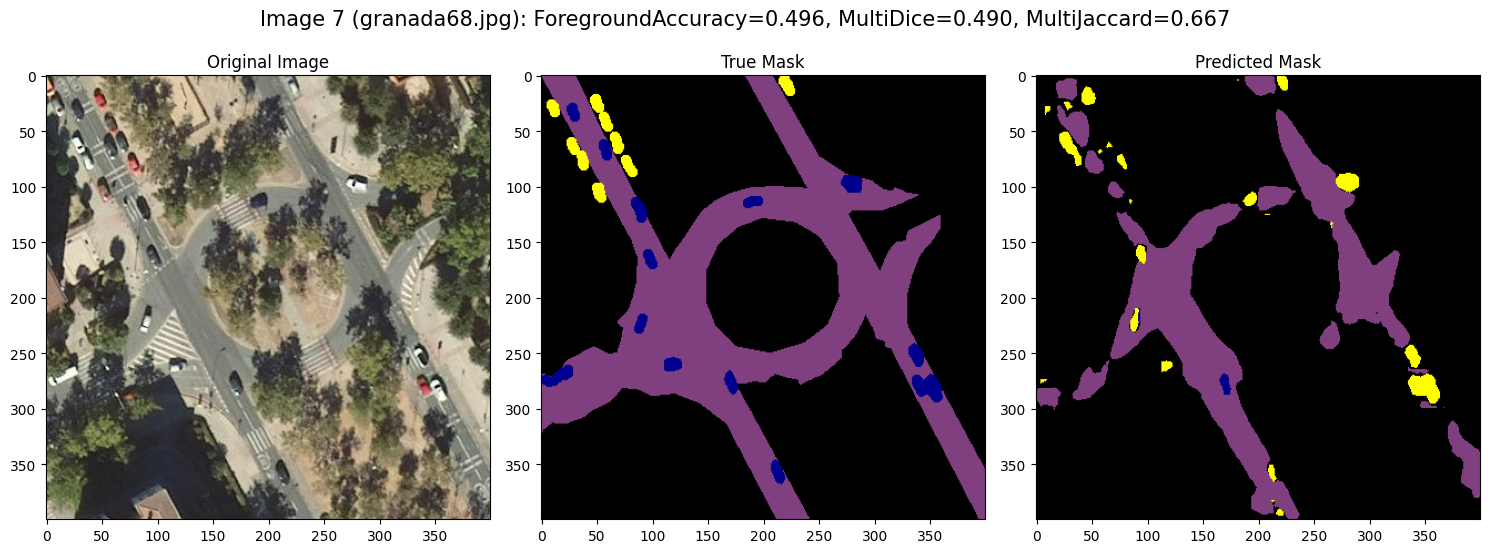

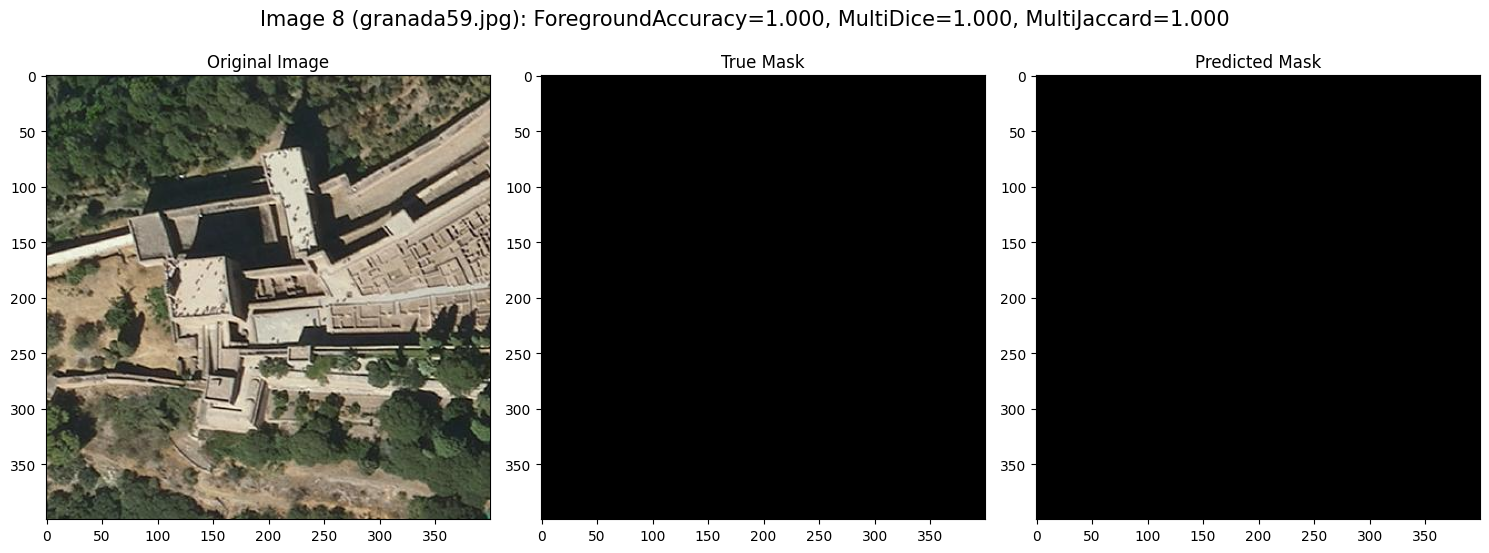

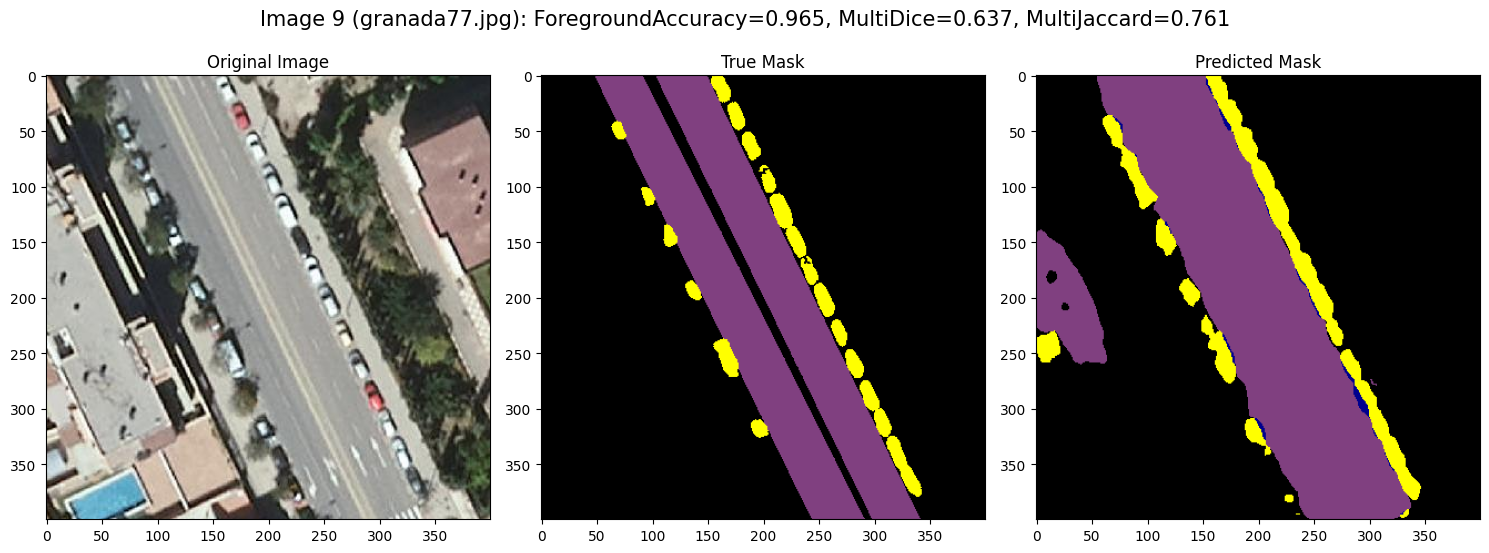

Mean Foreground Accuracy: 0.792
Mean MultiDice: 0.678
Mean MultiJaccard: 0.773


In [ ]:
def map_class_to_color(mask, mapping):
    # Crear un array vacío con 3 canales para los colores RGB
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    for k, v in mapping.items():
        # Mapear cada clase a su color RGB correspondiente
        color_mask[mask == v] = k

    return color_mask

preds, targs = learner.get_preds(dl=dls_test.train)

accuracies = []
dices = []
jaccards = []

for i, (img, targ) in enumerate(dls_test.dataset):
    pred = preds[i]
    targ = targs[i]

    predicted_mask_np = np.array(pred.argmax(dim=0))
    true_mask_np = np.array(targ)

    accuracy = foreground_acc_simple(predicted_mask_np, true_mask_np)
    accuracies.append(accuracy)

    dice = dice_multi(predicted_mask_np, true_mask_np)
    dices.append(dice)

    jaccard = jaccard_multi(predicted_mask_np, true_mask_np)
    jaccards.append(jaccard)


    plt.figure(figsize=(15, 6))

    # Añadir métricas como texto en la parte inferior
    plt.subplot(1, 3, 1)
    plt.imshow(img)  # Ajusta si es necesario
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(map_class_to_color(true_mask_np, mapping_class_color))
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(map_class_to_color(predicted_mask_np, mapping_class_color))
    plt.title("Predicted Mask")

    plt.figtext(0.5, 0.98,
            f'Image {i} ({os.path.basename(dls_test.items[i])}): ForegroundAccuracy={accuracy:.3f}, MultiDice={dice:.3f}, MultiJaccard={jaccard:.3f}',
            ha='center', va='top', fontsize=15)


    plt.tight_layout()
    plt.show()

mean_accuracy = sum(accuracies) / len(accuracies)
mean_dice = sum(dices) / len(dices)
mean_jaccard = sum(jaccards) / len(jaccards)

print(f'Mean Foreground Accuracy: {mean_accuracy:.3f}')
print(f'Mean MultiDice: {mean_dice:.3f}')
print(f'Mean MultiJaccard: {mean_jaccard:.3f}')
